# Import needed libraries

In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Activation, Dropout, Flatten,\
                         Conv2D, MaxPooling2D, BatchNormalization, concatenate, Cropping2D, Average
from tensorflow.keras import regularizers
from tensorflow.keras import optimizers
from sklearn.metrics import classification_report, confusion_matrix,ConfusionMatrixDisplay
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import matplotlib.pyplot as plt
import os
import pickle
import time
import tqdm

2024-01-07 19:48:03.277168: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-07 19:48:03.277265: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-07 19:48:03.336710: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-07 19:48:03.463246: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-07 19:48:05.354140: W tensorflow/compiler/tf2

In [2]:
device_name = tf.test.gpu_device_name()
print(device_name)

/device:GPU:0


2024-01-07 19:48:09.967424: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-07 19:48:10.293406: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-07 19:48:10.293460: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-07 19:48:13.231484: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-07 19:48:13.231673: I external/local_xla/xla/stream_executor

# Load Data

In [3]:
trainingset = 'train'
testset = 'test'

batch_size = 16

"""
train_datagen = ImageDataGenerator(
    zoom_range=0.3,\
    rotation_range=20,\
    width_shift_range=0.2,\
    height_shift_range=0.2,\
    horizontal_flip=True,\
    vertical_flip=False
    )
"""
train_datagen = ImageDataGenerator()

#Generate batches of image data and their corresponding labels from a directory structure
train_generator = train_datagen.flow_from_directory(
    directory=trainingset,
    target_size=(96, 96),
    color_mode="rgb",
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=True)

test_datagen = ImageDataGenerator()

test_generator = test_datagen.flow_from_directory(
    directory=testset,
    target_size=(96, 96),
    color_mode="rgb",
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False
)

num_samples = train_generator.n
num_classes = train_generator.num_classes
input_shape = train_generator.image_shape

classnames = [k for k,v in train_generator.class_indices.items()]

print("Image input %s" %str(input_shape))
print("Classes: %r" %classnames)
print('Loaded %d training samples from %d classes.' %(num_samples,num_classes))
print('Loaded %d test samples from %d classes.' %(test_generator.n,test_generator.num_classes))


Found 6369 images belonging to 5 classes.
Found 2749 images belonging to 5 classes.
Image input (96, 96, 3)
Classes: ['0', '1', '2', '3', '4']
Loaded 6369 training samples from 5 classes.
Loaded 2749 test samples from 5 classes.


## Data distribution

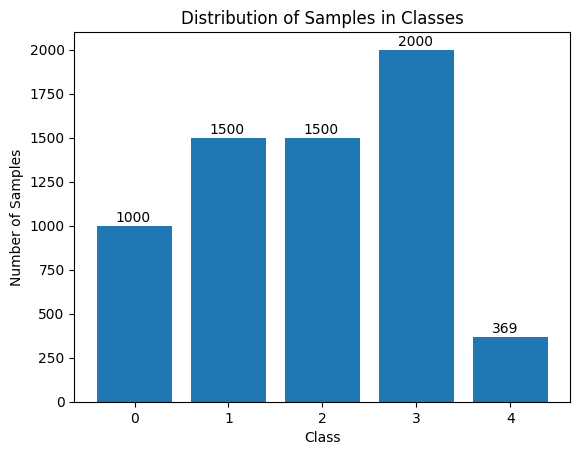

In [4]:
# Count the number of samples 
class_counts = {class_name: 0 for class_name in np.unique(train_generator.classes)}
for label in train_generator.classes:
    class_counts[label] += 1
    if sum(class_counts.values()) >= num_samples:
        break

# Plot the distribution
bars = plt.bar(class_counts.keys(), class_counts.values())
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.title('Distribution of Samples in Classes')
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x()+0.2, yval + 25, yval,)
plt.show()


# Model I

In [5]:

def ModelI(input_shape, num_classes, lr=0.0001):

    model = Sequential()

    # C1 Convolutional Layer
    model.add(Conv2D(filters=32, input_shape=input_shape, kernel_size=(5,5)))
    model.add(Activation('relu'))
    # Pooling
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
    # Batch Normalisation before passing it to the next layer
    model.add(BatchNormalization())

    # C2 Convolutional Layer
    model.add(Conv2D(filters=64, kernel_size=(3,3)))
    model.add(Activation('relu'))
    # Pooling
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
    # Batch Normalisation
    model.add(BatchNormalization())

    # Flatten
    model.add(Flatten())

    flatten_shape = (input_shape[0]*input_shape[1]*input_shape[2],)

    # Dense Layer
    # model.add(Dense(128, input_shape=flatten_shape, kernel_regularizer=regularizers.l2(regl2)))
    model.add(Dense(128, input_shape=flatten_shape))
    model.add(Activation('relu'))
    # Dropout
    model.add(Dropout(0.4))
    # Batch Normalisation
    model.add(BatchNormalization())

    # Output Layer
    model.add(Dense(num_classes))
    model.add(Activation('softmax'))

    # Compile
    adam = optimizers.Adam(learning_rate=lr)
    model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

    return model

# create the model
model1 = ModelI(input_shape,num_classes)
model1.summary()

# define the callback
callback1 = tf.keras.callbacks.EarlyStopping(monitor='loss',patience=4)

# history of results (set to None when initializing a new mdoel)
history = None


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 92, 92, 32)        2432      
                                                                 
 activation (Activation)     (None, 92, 92, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 46, 46, 32)        0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 46, 46, 32)        128       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 44, 44, 64)        18496     
                                                                 
 activation_1 (Activation)   (None, 44, 44, 64)        0

2024-01-07 19:48:14.040514: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-07 19:48:14.040724: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-07 19:48:14.040772: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-07 19:48:14.041057: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-07 19:48:14.041100: I external/local_xla/xla/stream_executor

## Train

In [6]:
class_weights = compute_class_weight(class_weight = 'balanced', classes = np.unique(train_generator.classes), y = train_generator.classes)
class_weight_dict = dict(enumerate(class_weights))
print(class_weight_dict)

{0: 1.2738, 1: 0.8492, 2: 0.8492, 3: 0.6369, 4: 3.4520325203252034}


In [7]:
%%time
steps_per_epoch=train_generator.n//train_generator.batch_size
#val_steps=test_generator.n//test_generator.batch_size+1

epochs = 100  # sets number of epochs


try:
    h = model1.fit(train_generator, epochs=epochs, verbose=1,\
                    steps_per_epoch=steps_per_epoch,\
                    class_weight=class_weight_dict,\
                    callbacks=[callback1],
                    #validation_data=test_generator,\
                    #validation_steps=val_steps
                    )
except KeyboardInterrupt:
    pass

# append current history
if history is None:
    history = h.history
else:
    history['loss'].extend(h.history['loss'])
    history['accuracy'].extend(h.history['accuracy'])
    #history['val_loss'].extend(h.history['val_loss'])
    #history['val_accuracy'].extend(h.history['val_accuracy'])

print("number of epochs trained: %d" %len(history['loss']))


Epoch 1/100


2024-01-07 19:48:17.523840: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8902
2024-01-07 19:48:20.075366: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-01-07 19:48:21.754662: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-01-07 19:48:22.904136: I external/local_xla/xla/service/service.cc:168] XLA service 0x7fdea4002200 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-01-07 19:48:22.904209: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce MX150, Compute Capability 6.1
2024-01-07 19:48:23.034702: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1704653303.225250   51546 device_compiler.h:1

398/398 [==============================] - 25s 35ms/step - loss: 1.4737 - accuracy: 0.4412
Epoch 2/100
398/398 [==============================] - 13s 32ms/step - loss: 1.3217 - accuracy: 0.5065
Epoch 3/100
398/398 [==============================] - 13s 33ms/step - loss: 1.2907 - accuracy: 0.5196
Epoch 4/100
398/398 [==============================] - 13s 33ms/step - loss: 1.2411 - accuracy: 0.5322
Epoch 5/100
398/398 [==============================] - 13s 33ms/step - loss: 1.2095 - accuracy: 0.5459
Epoch 6/100
398/398 [==============================] - 13s 33ms/step - loss: 1.2238 - accuracy: 0.5475
Epoch 7/100
398/398 [==============================] - 13s 33ms/step - loss: 1.1862 - accuracy: 0.5534
Epoch 8/100
398/398 [==============================] - 14s 34ms/step - loss: 1.1470 - accuracy: 0.5730
Epoch 9/100
398/398 [==============================] - 14s 34ms/step - loss: 1.1435 - accuracy: 0.5737
Epoch 10/100
398/398 [==============================] - 14s 35ms/step - loss: 1.1195 

In [ ]:
# summarize history for accuracy
plt.plot(history['accuracy'])
#plt.plot(history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
#plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history['loss'])
#plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
#plt.legend(['train', 'test'], loc='upper left') #label of line
plt.show()

### Save model

In [10]:
models_dir = 'models'
modelname = 'model1_%d_epochs_weg.h5' %len(history['loss'])
model1.save(os.path.join(models_dir,modelname))

/home/gioia/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## Evaluate

In [ ]:
#model = tf.keras.models.load_model('models/model1_NoAug_20_epochs.h5')

In [8]:
val_steps=test_generator.n//test_generator.batch_size+1
print(val_steps)
loss, acc = model1.evaluate(test_generator,verbose=1,steps=val_steps)
pred = model1.predict(test_generator,verbose=1,steps=val_steps).argmax(axis=1)
#print(pred)
print('Test loss: %f' %loss)
print('Test accuracy: %f' %acc)
print(classification_report(test_generator.classes, pred, target_names=classnames,digits=4))


172
172/172 [==============================] - 2s 8ms/step
Test loss: 2.786995
Test accuracy: 0.463077
              precision    recall  f1-score   support

           0     0.1993    0.4060    0.2673       133
           1     0.3216    0.6327    0.4265       275
           2     0.3151    0.7389    0.4418       406
           3     0.8913    0.3892    0.5419      1896
           4     0.0446    0.1795    0.0714        39

    accuracy                         0.4631      2749
   macro avg     0.3544    0.4693    0.3498      2749
weighted avg     0.7037    0.4631    0.4956      2749



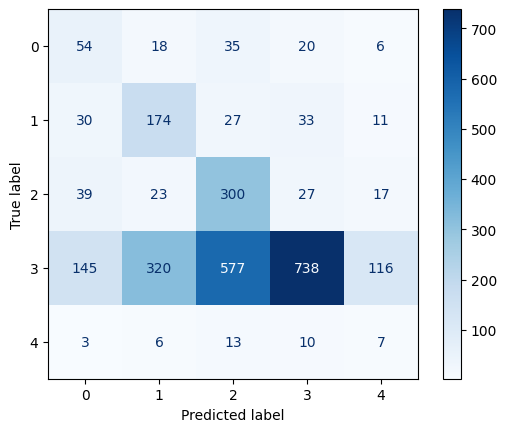

True                 Predicted         	errors 	err % 
------------------------------------------------------------------
3                ->  2                 	577 	20.99 % 
3                ->  1                 	320 	11.64 % 
3                ->  0                 	145 	5.27 % 
3                ->  4                 	116 	4.22 % 
2                ->  0                 	39 	1.42 % 
0                ->  2                 	35 	1.27 % 
1                ->  3                 	33 	1.20 % 
1                ->  0                 	30 	1.09 % 
1                ->  2                 	27 	0.98 % 
2                ->  3                 	27 	0.98 % 
2                ->  1                 	23 	0.84 % 
0                ->  3                 	20 	0.73 % 
0                ->  1                 	18 	0.65 % 
2                ->  4                 	17 	0.62 % 
4                ->  2                 	13 	0.47 % 
1                ->  4                 	11 	0.40 % 
4                ->  3                 	

In [9]:
ytest = test_generator.classes
cm = confusion_matrix(ytest, pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=classnames)
disp.plot(cmap=plt.cm.Blues)
plt.show()


conf = [] # data structure for confusions: list of (i,j,cm[i][j])
for i in range(0,cm.shape[0]):
  for j in range(0,cm.shape[1]):
    if (i!=j and cm[i][j]>0):
      conf.append([i,j,cm[i][j]])

col=2
conf = np.array(conf)
conf = conf[np.argsort(-conf[:,col])]  # decreasing order by 3-rd column (i.e., cm[i][j])

print('%-16s     %-16s  \t%s \t%s ' %('True','Predicted','errors','err %'))
print('------------------------------------------------------------------')
for k in conf:
  print('%-16s ->  %-16s  \t%d \t%.2f %% ' %(classnames[k[0]],classnames[k[1]],k[2],k[2]*100.0/test_generator.n))

# Model II

In [8]:
def model2(input_shape, num_classes, lr = 0.001):
    input_layer = Input(input_shape) 

    # 4 cov layers
    x = Conv2D(32, (3, 3), activation='relu')(input_layer)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(128, (3, 3), activation='relu')(x)
    #x = Conv2D(128, (3, 3), activation='relu')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(256, (3, 3), activation='relu')(x)
    x = MaxPooling2D((2, 2))(x)
    x = BatchNormalization()(x)
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.4)(x)
    output_layer = Dense(num_classes, activation='softmax')(x)


    # Create and compile the composite model
    adam = optimizers.Adam(learning_rate=lr)
    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

    return model

model2 = model2(input_shape, num_classes)

# Print the model summary
model2.summary()

# define the callback
callback2 = tf.keras.callbacks.EarlyStopping(monitor='loss',patience=3)

history = None

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 94, 94, 32)        896       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 47, 47, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 45, 45, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 22, 22, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 20, 20, 128)       7385

## Train

In [ ]:
class_weights = compute_class_weight(class_weight = 'balanced', classes = np.unique(train_generator.classes), y = train_generator.classes)
class_weight_dict = dict(enumerate(class_weights))
print(class_weight_dict)

In [9]:
%%time
steps_per_epoch=train_generator.n//train_generator.batch_size
val_steps=test_generator.n//test_generator.batch_size+1

epochs = 100  # sets number of epochs

h = model2.fit(train_generator, epochs=epochs, verbose=1,\
                    steps_per_epoch=steps_per_epoch,\
                    #class_weight=class_weight_dict,\
                    callbacks=[callback2]
                    #validation_data=test_generator,\
                    #validation_steps=val_steps
                    )


# append current history
if history is None:
    history = h.history
else:
    history['loss'].extend(h.history['loss'])
    history['accuracy'].extend(h.history['accuracy'])
    #history['val_loss'].extend(h.history['val_loss'])
    #history['val_accuracy'].extend(h.history['val_accuracy'])

print("number of epochs trained: %d" %len(history['loss']))


Epoch 1/100
398/398 [==============================] - 36s 41ms/step - loss: 1.3502 - accuracy: 0.5039
Epoch 2/100
398/398 [==============================] - 16s 40ms/step - loss: 1.2179 - accuracy: 0.5459
Epoch 3/100
398/398 [==============================] - 16s 40ms/step - loss: 1.2019 - accuracy: 0.5563
Epoch 4/100
398/398 [==============================] - 16s 40ms/step - loss: 1.1905 - accuracy: 0.5589
Epoch 5/100
398/398 [==============================] - 16s 40ms/step - loss: 1.1855 - accuracy: 0.5626
Epoch 6/100
398/398 [==============================] - 16s 40ms/step - loss: 1.1631 - accuracy: 0.5695
Epoch 7/100
398/398 [==============================] - 16s 40ms/step - loss: 1.1662 - accuracy: 0.5651
Epoch 8/100
398/398 [==============================] - 16s 40ms/step - loss: 1.1508 - accuracy: 0.5747
Epoch 9/100
398/398 [==============================] - 16s 40ms/step - loss: 1.1468 - accuracy: 0.5785
Epoch 10/100
398/398 [==============================] - 16s 41ms/step - l

: 

## Evaluate

In [7]:
val_steps=test_generator.n//test_generator.batch_size+1
print(val_steps)
loss, acc = model2.evaluate(test_generator,verbose=1,steps=val_steps)
pred = model2.predict(test_generator,verbose=1,steps=val_steps).argmax(axis=1)
#print(pred)
print('Test loss: %f' %loss)
print('Test accuracy: %f' %acc)
print(classification_report(test_generator.classes, pred, target_names=classnames,digits=4))

172
172/172 [==============================] - 2s 10ms/step
Test loss: 3.384658
Test accuracy: 0.441251
              precision    recall  f1-score   support

           0     0.1550    0.5489    0.2417       133
           1     0.2680    0.6764    0.3839       275
           2     0.4003    0.7365    0.5186       406
           3     0.8994    0.3444    0.4981      1896
           4     0.0180    0.0513    0.0267        39

    accuracy                         0.4413      2749
   macro avg     0.3481    0.4715    0.3338      2749
weighted avg     0.7140    0.4413    0.4706      2749



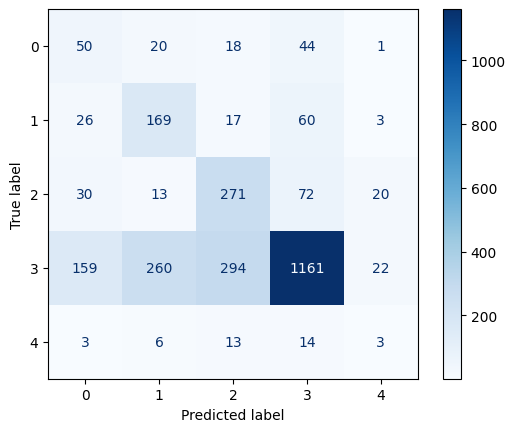

True                 Predicted         	errors 	err % 
------------------------------------------------------------------
3                ->  2                 	294 	10.69 % 
3                ->  1                 	260 	9.46 % 
3                ->  0                 	159 	5.78 % 
2                ->  3                 	72 	2.62 % 
1                ->  3                 	60 	2.18 % 
0                ->  3                 	44 	1.60 % 
2                ->  0                 	30 	1.09 % 
1                ->  0                 	26 	0.95 % 
3                ->  4                 	22 	0.80 % 
0                ->  1                 	20 	0.73 % 
2                ->  4                 	20 	0.73 % 
0                ->  2                 	18 	0.65 % 
1                ->  2                 	17 	0.62 % 
4                ->  3                 	14 	0.51 % 
4                ->  2                 	13 	0.47 % 
2                ->  1                 	13 	0.47 % 
4                ->  1                 	6 

In [11]:
ytest = test_generator.classes
cm = confusion_matrix(ytest, pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=classnames)
disp.plot(cmap=plt.cm.Blues)
plt.show()


conf = [] # data structure for confusions: list of (i,j,cm[i][j])
for i in range(0,cm.shape[0]):
  for j in range(0,cm.shape[1]):
    if (i!=j and cm[i][j]>0):
      conf.append([i,j,cm[i][j]])

col=2
conf = np.array(conf)
conf = conf[np.argsort(-conf[:,col])]  # decreasing order by 3-rd column (i.e., cm[i][j])

print('%-16s     %-16s  \t%s \t%s ' %('True','Predicted','errors','err %'))
print('------------------------------------------------------------------')
for k in conf:
  print('%-16s ->  %-16s  \t%d \t%.2f %% ' %(classnames[k[0]],classnames[k[1]],k[2],k[2]*100.0/test_generator.n))

In [12]:
model2.save('models/model2' + str(len(history['loss'])) + '_epochs')

INFO:tensorflow:Assets written to: models/model250_epochs/assets


INFO:tensorflow:Assets written to: models/model250_epochs/assets


In [ ]:
models_dir = 'models'
modelname = 'composite_model_%d_epochs' %len(history['loss'])

def savemodel(problem,model):
    filename = os.path.join(models_dir, problem)
    model.save(filename)
    print("\nModel saved successfully on file %s\n" %filename)
    
    """
    filename = os.path.join(models_dir, '%s_history.pkl' %problem)
    with open(filename, 'wb') as f:
        pickle.dump(history, f)
    print("History saved successfully on file %s\n" %filename)
    """

# Save model and history
savemodel(modelname,composite_model)


: 